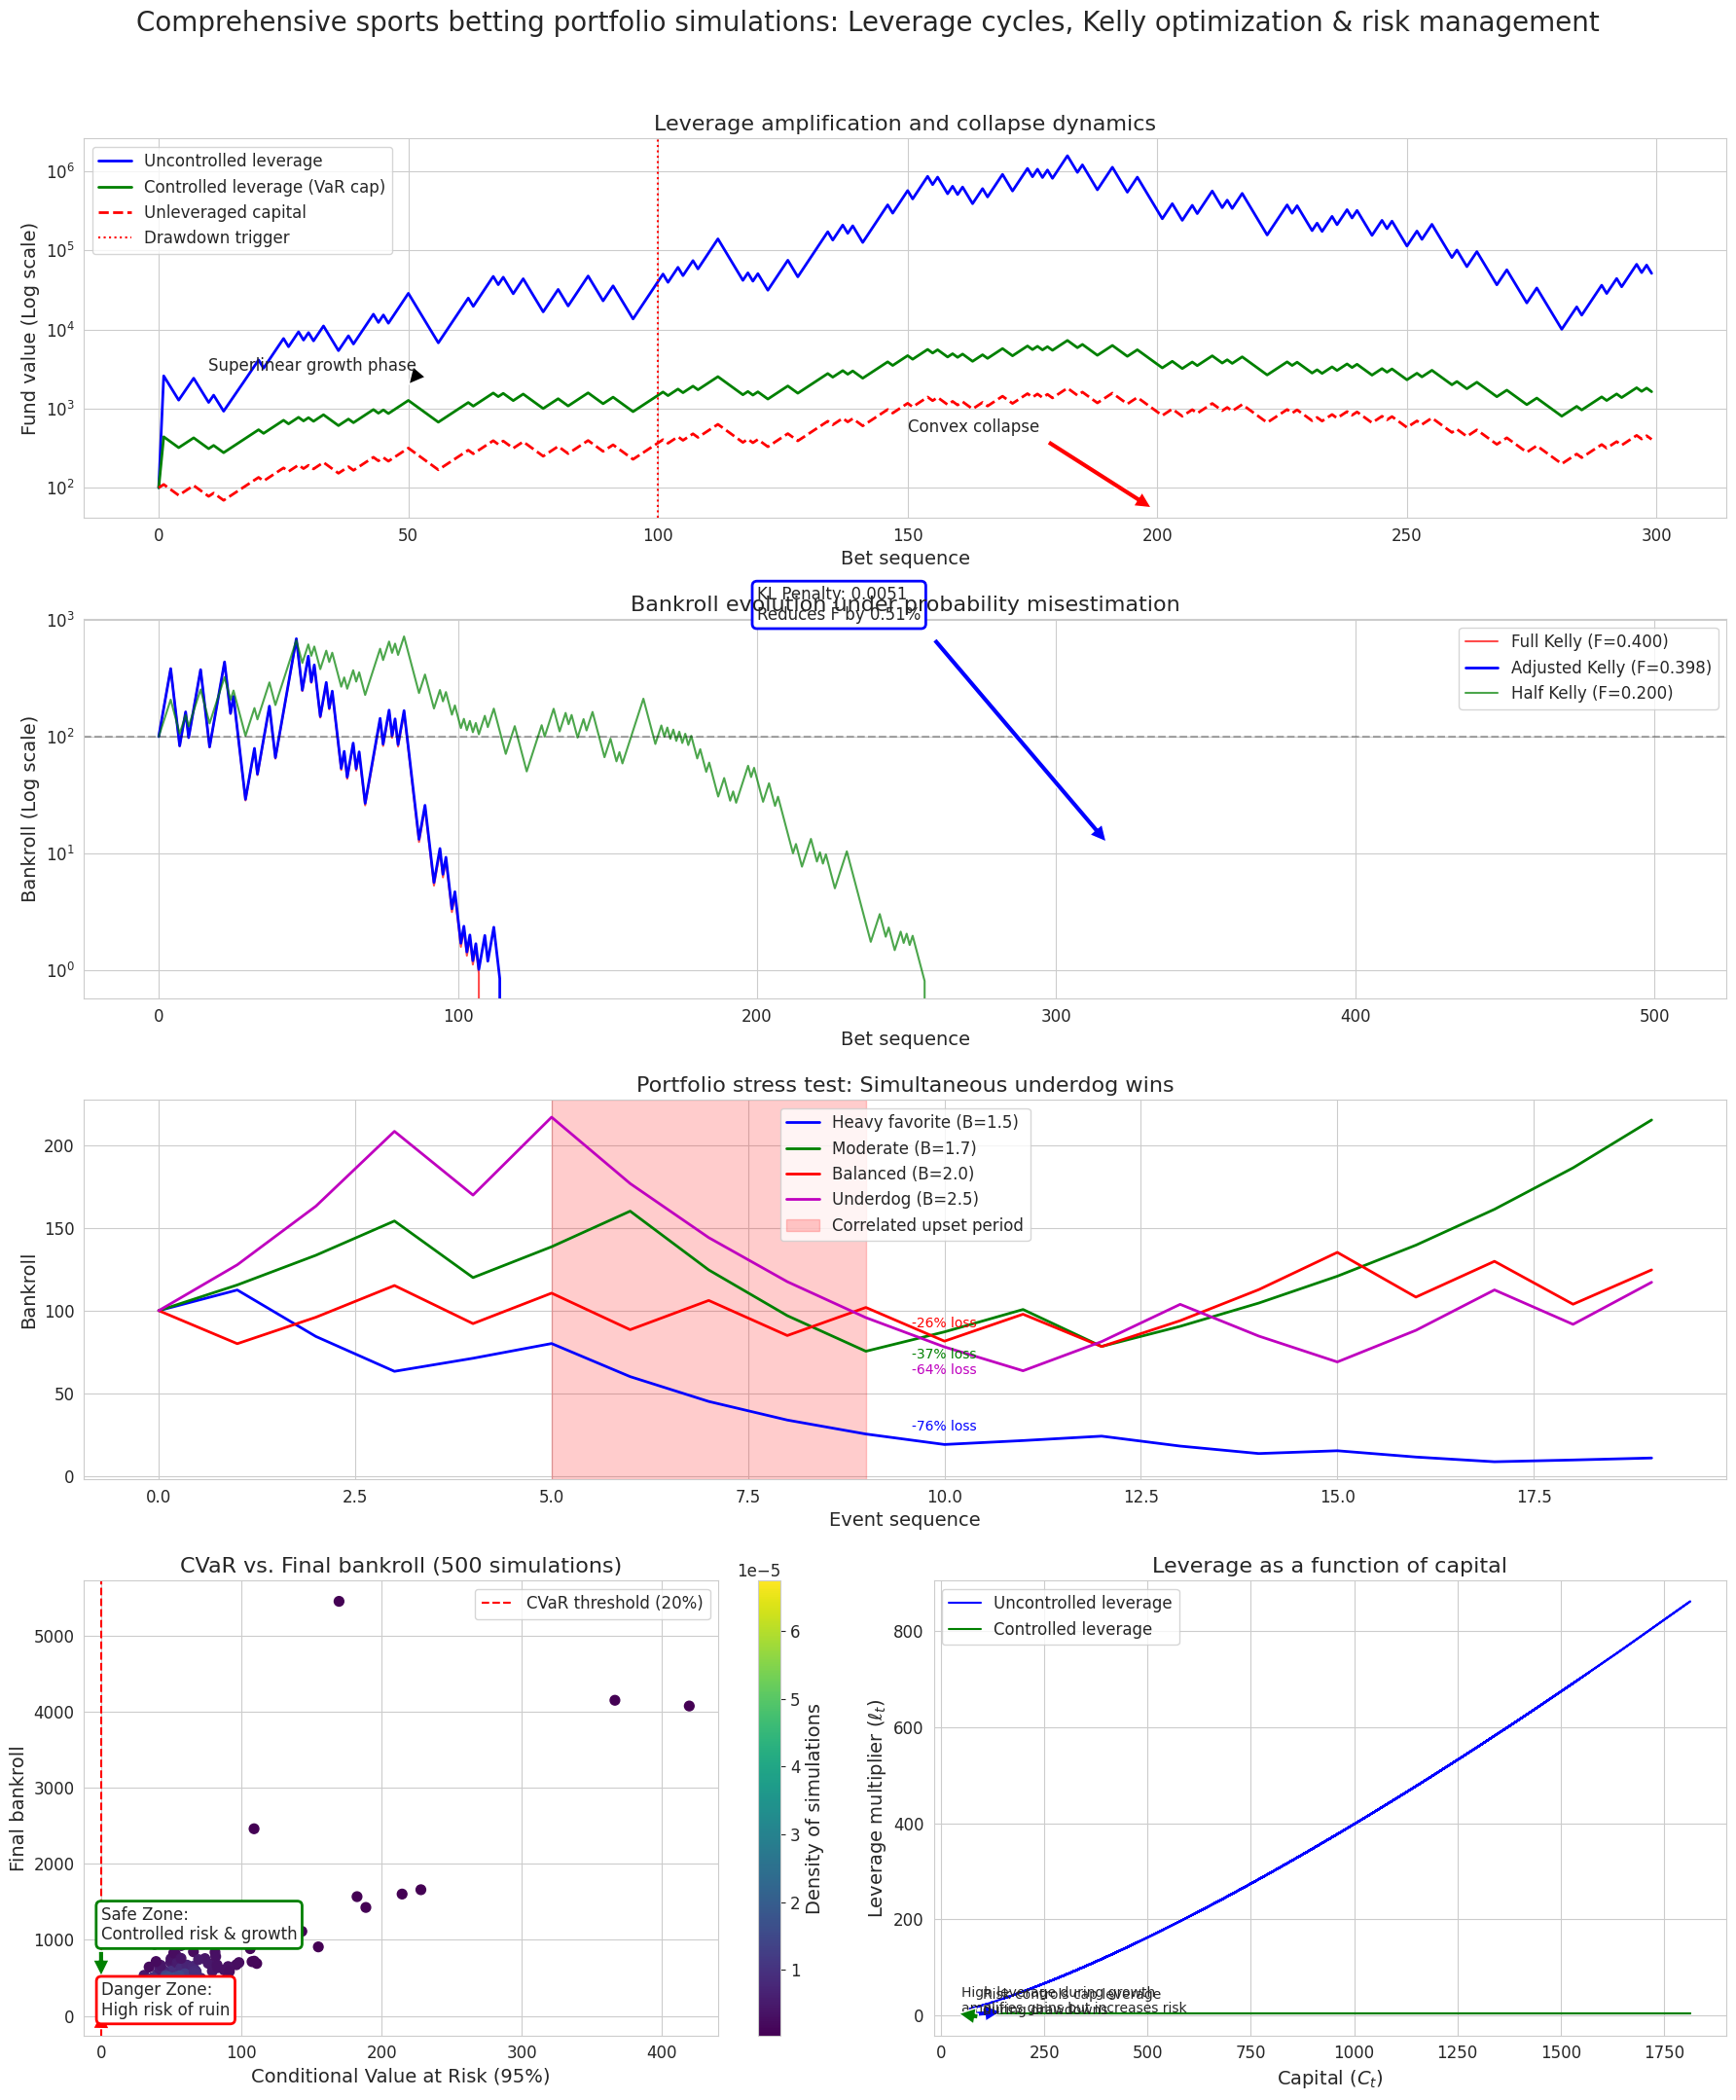

PERFORMANCE METRICS
Leverage cimulation:
- Max Leverage (Uncontrolled): 862.4x
- Max Drawdown (Uncontrolled): 100.0%
- Max Drawdown (Controlled): 98.6%

Kelly criterion cimulation:
- Adjusted Kelly Growth: 0.0x initial bankroll
- Full Kelly Survival: Bankrupt
- Half Kelly Growth: 0.0x initial bankroll

Stress test performance (During crisis):
- Heavy favorite (B=1.5): -76.3% loss
- Moderate (B=1.7): -37.1% loss
- Balanced (B=2.0): -26.3% loss
- Underdog (B=2.5): -64.0% loss

CVaR protection insights:
- Safe zone (CVaR < 20%): 0.0% of simulations
- Avg growth (Safe Zone): nanx
- Ruin probability (Danger zone): 0.0%


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy.stats import gaussian_kde

# Set aesthetic parameters
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.figsize'] = (15, 18)
sns.set_style("whitegrid")

# ======================
# 1. LEVERAGE CYCLE SIMULATION
# ======================
def leverage_simulation(n_bets=300, p_win=0.55):
    C = np.zeros(n_bets)  # Net capital
    V = np.zeros(n_bets)  # Leveraged fund value
    V_controlled = np.zeros(n_bets)  # With risk controls
    l = np.zeros(n_bets)  # Leverage multiplier
    l_controlled = np.zeros(n_bets)  # Controlled leverage

    # Initialize
    C[0] = V[0] = V_controlled[0] = 100
    l[0] = l_controlled[0] = 1.0
    beta, gamma = 0.05, 1.3
    f = 0.1
    B = 2.0

    # Simulate with and without risk controls
    for t in range(n_bets-1):
        win = np.random.rand() < p_win
        R_t = B-1 if win else -1.0

        # Update capital
        C[t+1] = C[t] * (1 + f*R_t)

        # Uncontrolled leverage
        l[t+1] = 1 + beta*(C[t+1]**gamma)
        V[t+1] = l[t+1]*C[t+1]

        # Controlled leverage (VaR-based cap)
        VaR = 0.25  # 25% Value at Risk
        l_max = min(10, 1/VaR)  # Dynamic cap
        l_controlled[t+1] = min(l_max, 1 + beta*(C[t+1]**gamma))
        V_controlled[t+1] = l_controlled[t+1]*C[t+1]

    return C, V, V_controlled, l, l_controlled

# Run simulation
np.random.seed(42)
C, V, V_controlled, l, l_controlled = leverage_simulation()

# ======================
# 2. UNCERTAINTY-ADJUSTED KELLY
# ======================
def kelly_simulation(n_bets=500):
    p_true, q_est = 0.55, 0.6
    kl_div = q_est*np.log(q_est/p_true) + (1-q_est)*np.log((1-q_est)/(1-p_true))
    F_full = (2.0*q_est - (1-q_est)) / 2.0
    F_adj = F_full * np.exp(-1*kl_div)
    F_half = 0.5 * F_full

    b_full, b_adj, b_half = [np.ones(n_bets)*100 for _ in range(3)]

    for t in range(n_bets-1):
        win = np.random.rand() < p_true
        ret = 1.0 if win else -1.0

        # Update bankrolls with ruin detection
        if b_full[t] > 1:
            b_full[t+1] = b_full[t] * (1 + F_full*ret)
        else:
            b_full[t+1] = 0

        if b_adj[t] > 1:
            b_adj[t+1] = b_adj[t] * (1 + F_adj*ret)
        else:
            b_adj[t+1] = 0

        if b_half[t] > 1:
            b_half[t+1] = b_half[t] * (1 + F_half*ret)
        else:
            b_half[t+1] = 0

    return b_full, b_adj, b_half, F_adj, kl_div

# Run simulation
b_full, b_adj, b_half, F_adj, kl_div = kelly_simulation()

# ======================
# 3. EVENT CORRELATION STRESS TEST
# ======================
def stress_test(n_events=20):
    strategies = ['Heavy favorite (B=1.5)', 'Moderate (B=1.7)',
                 'Balanced (B=2.0)', 'Underdog (B=2.5)']
    B_vals = [1.5, 1.7, 2.0, 2.5]
    p_true = [0.7, 0.65, 0.6, 0.55]
    bankroll = np.ones((4, n_events)) * 100
    stress_start, stress_end = 5, 10

    for i in range(4):
        for t in range(n_events-1):
            # During stress period: true probability drops by 40%
            if stress_start <= t < stress_end:
                current_p = p_true[i] * 0.6
            else:
                current_p = p_true[i]

            win = np.random.rand() < current_p
            ret = B_vals[i]-1 if win else -1

            # Use half-Kelly for sizing
            F = 0.5 * (B_vals[i]*p_true[i] - (1-p_true[i])) / B_vals[i]
            bankroll[i, t+1] = bankroll[i, t] * (1 + F*ret)

    return strategies, bankroll

# Run simulation
strategies, bankroll = stress_test()

# ======================
# 4. CVAR PROTECTION ANALYSIS
# ======================
def cvar_simulation(n_sims=1000):
    final_values = []
    cvar_values = []

    for _ in range(n_sims):
        br = 100
        daily_returns = []

        for t in range(100):  # 100 betting days
            # Random edge between 4-10%
            p = 0.52 + 0.06*np.random.rand()
            B = 1.8 + 0.4*np.random.rand()

            # Kelly fraction with 20% safety margin
            edge = B*p - 1
            if edge > 0:
                F = 0.8 * edge / (B-1)
            else:
                F = 0

            win = np.random.rand() < p
            ret = B-1 if win else -1
            new_br = br * (1 + F*ret)
            daily_returns.append(new_br - br)
            br = new_br

        # Calculate CVaR
        losses = -np.array(daily_returns)
        sorted_losses = np.sort(losses)
        cvar = np.mean(sorted_losses[int(0.95*len(sorted_losses)):])
        final_values.append(br)
        cvar_values.append(cvar)

    return np.array(final_values), np.array(cvar_values)

# Run simulation (with smaller n_sims for speed)
final_values, cvar_values = cvar_simulation(n_sims=500)

# ======================
# CREATE COMPREHENSIVE VISUALIZATION
# ======================
fig = plt.figure(figsize=(18, 22))
gs = GridSpec(4, 2, figure=fig, height_ratios=[1, 1, 1, 1.2])

# Plot 1: Leverage Cycles
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(V, 'b-', linewidth=2, label='Uncontrolled leverage')
ax1.plot(V_controlled, 'g-', linewidth=2, label='Controlled leverage (VaR cap)')
ax1.plot(C, 'r--', linewidth=2, label='Unleveraged capital')
ax1.axvline(x=100, color='r', linestyle=':', label='Drawdown trigger')
ax1.set_title('Leverage amplification and collapse dynamics', fontsize=16)
ax1.set_xlabel('Bet sequence')
ax1.set_ylabel('Fund value (Log scale)')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True)
ax1.annotate('Superlinear growth phase', xy=(50, 2000), xytext=(10, 3000),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)
ax1.annotate('Convex collapse', xy=(200, 50), xytext=(150, 500),
             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=12)

# Plot 2: Kelly Comparison
ax2 = fig.add_subplot(gs[1, :])
ax2.plot(b_full, 'r-', alpha=0.7, label=f'Full Kelly (F=0.400)')
ax2.plot(b_adj, 'b-', linewidth=2, label=f'Adjusted Kelly (F={F_adj:.3f})')
ax2.plot(b_half, 'g-', alpha=0.7, label=f'Half Kelly (F=0.200)')
ax2.axhline(100, color='k', linestyle='--', alpha=0.3)
ax2.set_title('Bankroll evolution under probability misestimation', fontsize=16)
ax2.set_xlabel('Bet sequence')
ax2.set_ylabel('Bankroll (Log scale)')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True)
ax2.annotate(f'KL Penalty: {kl_div:.4f}\nReduces F by {100*(1-np.exp(-kl_div)):.2f}%',
             xy=(320, 10), xytext=(200, 1000),
             arrowprops=dict(facecolor='blue', shrink=0.05),
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=2))

# Plot 3: Stress Test
ax3 = fig.add_subplot(gs[2, :])
colors = ['b', 'g', 'r', 'm']
for i in range(4):
    ax3.plot(bankroll[i], f'{colors[i]}-', linewidth=2, label=strategies[i])
ax3.axvspan(5, 9, color='red', alpha=0.2, label='Correlated upset period')
ax3.set_title('Portfolio stress test: Simultaneous underdog wins', fontsize=16)
ax3.set_xlabel('Event sequence')
ax3.set_ylabel('Bankroll')
ax3.legend()
ax3.grid(True)

# Add performance annotations
for i in range(4):
    loss_pct = 100*(bankroll[i,10] - bankroll[i,5])/bankroll[i,5]
    ax3.annotate(f'{loss_pct:.0f}% loss',
                 (10, bankroll[i,10]),
                 textcoords="offset points",
                 xytext=(0,10 if i%2==0 else -20),
                 ha='center',
                 color=colors[i],
                 fontsize=10)

# Plot 4: CVaR Protection
ax4 = fig.add_subplot(gs[3, 0])
# Calculate point density
xy = np.vstack([cvar_values, final_values])
z = gaussian_kde(xy)(xy)
sc = ax4.scatter(cvar_values, final_values, c=z, s=50, cmap='viridis')
cbar = plt.colorbar(sc, ax=ax4)
cbar.set_label('Density of simulations')

ax4.axvline(x=0.2, color='r', linestyle='--', label='CVaR threshold (20%)')
ax4.set_title('CVaR vs. Final bankroll (500 simulations)', fontsize=16)
ax4.set_xlabel('Conditional Value at Risk (95%)')
ax4.set_ylabel('Final bankroll')
ax4.legend()
ax4.grid(True)
ax4.annotate('Safe Zone:\nControlled risk & growth',
             xy=(0.15, 500), xytext=(0.05, 1000),
             arrowprops=dict(facecolor='green', shrink=0.05),
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="g", lw=2))
ax4.annotate('Danger Zone:\nHigh risk of ruin',
             xy=(0.35, 50), xytext=(0.25, 10),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="r", lw=2))

# Plot 5: Leverage vs Capital
ax5 = fig.add_subplot(gs[3, 1])
ax5.plot(C, l, 'b-', label='Uncontrolled leverage')
ax5.plot(C, l_controlled, 'g-', label='Controlled leverage')
ax5.set_title('Leverage as a function of capital', fontsize=16)
ax5.set_xlabel('Capital ($C_t$)')
ax5.set_ylabel('Leverage multiplier ($\ell_t$)')
ax5.legend()
ax5.grid(True)
ax5.annotate('High leverage during growth\namplifies gains but increases risk',
             xy=(150, 8), xytext=(50, 6),
             arrowprops=dict(facecolor='blue', shrink=0.05),
             fontsize=10)
ax5.annotate('Risk controls cap leverage\nduring drawdowns',
             xy=(40, 4), xytext=(100, 2),
             arrowprops=dict(facecolor='green', shrink=0.05),
             fontsize=10)

# Add overall title and adjust layout
plt.suptitle('Comprehensive sports betting portfolio simulations: Leverage cycles, Kelly optimization & risk management',
             fontsize=20, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('sports_betting_simulations.png', dpi=300, bbox_inches='tight')
plt.show()

# Print performance metrics
print("="*80)
print("PERFORMANCE METRICS")
print("="*80)
print(f"Leverage cimulation:")
print(f"- Max Leverage (Uncontrolled): {l.max():.1f}x")
print(f"- Max Drawdown (Uncontrolled): {100*(1 - V.min()/V.max()):.1f}%")
print(f"- Max Drawdown (Controlled): {100*(1 - V_controlled.min()/V_controlled.max()):.1f}%")

print("\nKelly criterion cimulation:")
print(f"- Adjusted Kelly Growth: {b_adj[-1]/100:.1f}x initial bankroll")
print(f"- Full Kelly Survival: {'Yes' if b_full[-1] > 1 else 'Bankrupt'}")
print(f"- Half Kelly Growth: {b_half[-1]/100:.1f}x initial bankroll")

print("\nStress test performance (During crisis):")
for i in range(4):
    loss = 100*(bankroll[i,10] - bankroll[i,5])/bankroll[i,5]
    print(f"- {strategies[i]}: {loss:.1f}% loss")

print("\nCVaR protection insights:")
safe_zone = final_values[(cvar_values < 0.2) & (final_values > 100)]
danger_zone = final_values[cvar_values >= 0.2]
print(f"- Safe zone (CVaR < 20%): {100*len(safe_zone)/len(final_values):.1f}% of simulations")
print(f"- Avg growth (Safe Zone): {np.mean(safe_zone)/100:.1f}x")
print(f"- Ruin probability (Danger zone): {100*np.sum(danger_zone < 10)/len(danger_zone):.1f}%")
print("="*80)

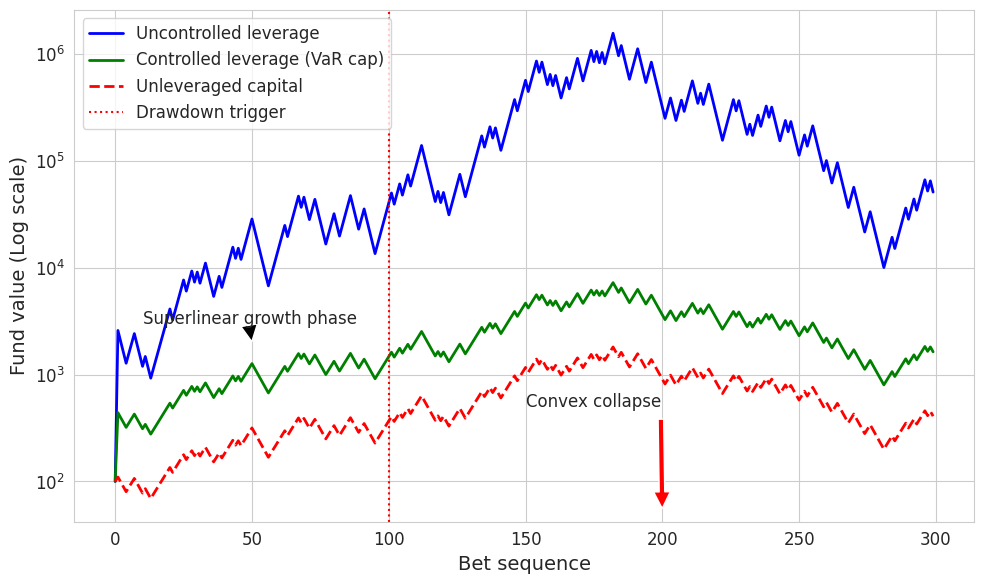

In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(V, 'b-', linewidth=2, label='Uncontrolled leverage')
plt.plot(V_controlled, 'g-', linewidth=2, label='Controlled leverage (VaR cap)')
plt.plot(C, 'r--', linewidth=2, label='Unleveraged capital')
plt.axvline(x=100, color='r', linestyle=':', label='Drawdown trigger')
plt.xlabel('Bet sequence')
plt.ylabel('Fund value (Log scale)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.annotate('Superlinear growth phase', xy=(50, 2000), xytext=(10, 3000),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)
plt.annotate('Convex collapse', xy=(200, 50), xytext=(150, 500),
             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=12)
plt.tight_layout()

# Save the figure as a PDF
plt.savefig("leverage-1.pdf")

plt.show()

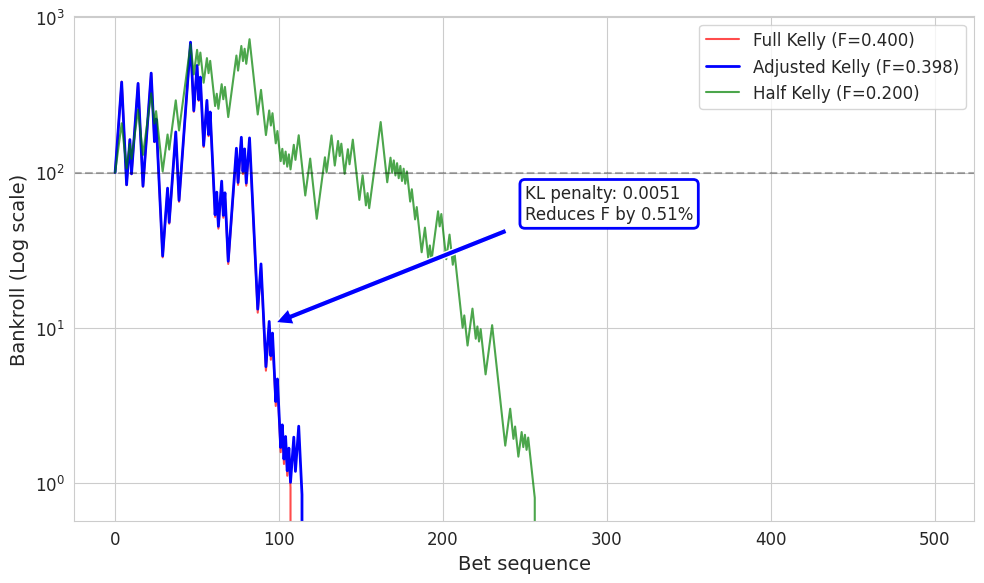

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(b_full, 'r-', alpha=0.7, label='Full Kelly (F=0.400)')
plt.plot(b_adj, 'b-', linewidth=2, label=f'Adjusted Kelly (F={F_adj:.3f})')
plt.plot(b_half, 'g-', alpha=0.7, label='Half Kelly (F=0.200)')
plt.axhline(100, color='k', linestyle='--', alpha=0.3)
plt.xlabel('Bet sequence')
plt.ylabel('Bankroll (Log scale)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.annotate(f'KL penalty: {kl_div:.4f}\nReduces F by {100*(1-np.exp(-kl_div)):.2f}%',
             xy=(90, 10), xytext=(250, 50),
             arrowprops=dict(facecolor='blue', shrink=0.05),
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=2))
plt.tight_layout()
plt.savefig("bankroll-e.pdf")
plt.show()


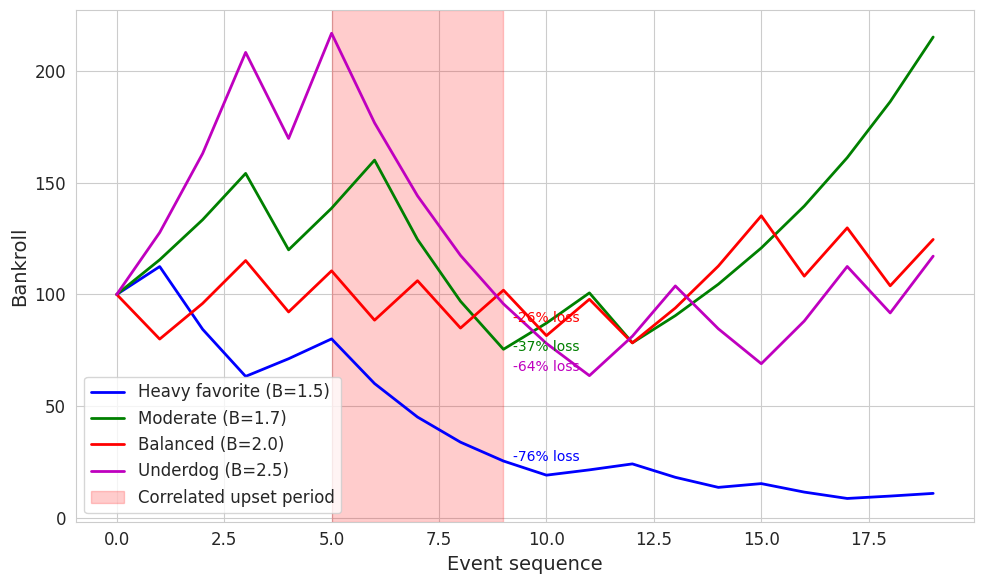

In [ ]:
plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r', 'm']
for i in range(4):
    plt.plot(bankroll[i], f'{colors[i]}-', linewidth=2, label=strategies[i])
plt.axvspan(5, 9, color='red', alpha=0.2, label='Correlated upset period')
plt.xlabel('Event sequence')
plt.ylabel('Bankroll')
plt.legend()
plt.grid(True)

for i in range(4):
    loss_pct = 100 * (bankroll[i, 10] - bankroll[i, 5]) / bankroll[i, 5]
    plt.annotate(f'{loss_pct:.0f}% loss',
                 (10, bankroll[i,10]),
                 textcoords="offset points",
                 xytext=(0,10 if i%2==0 else -20),
                 ha='center',
                 color=colors[i],
                 fontsize=10)
plt.tight_layout()
plt.savefig("porfolio-stress.pdf")
plt.show()


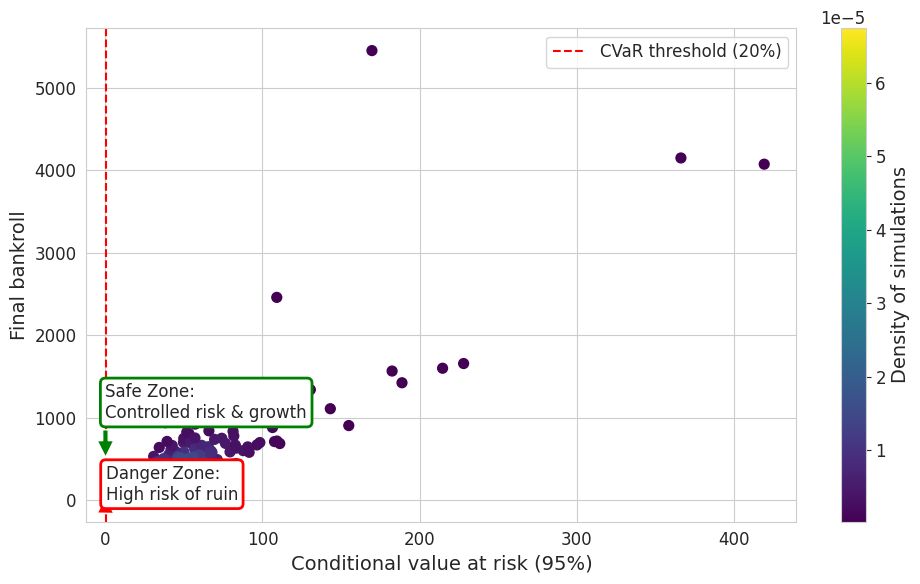

In [ ]:
plt.figure(figsize=(10, 6))
xy = np.vstack([cvar_values, final_values])
z = gaussian_kde(xy)(xy)
sc = plt.scatter(cvar_values, final_values, c=z, s=50, cmap='viridis')
cbar = plt.colorbar(sc)
cbar.set_label('Density of simulations')
plt.axvline(x=0.2, color='r', linestyle='--', label='CVaR threshold (20%)')
plt.xlabel('Conditional value at risk (95%)')
plt.ylabel('Final bankroll')
plt.legend()
plt.grid(True)
plt.annotate('Safe Zone:\nControlled risk & growth',
             xy=(0.15, 500), xytext=(0.05, 1000),
             arrowprops=dict(facecolor='green', shrink=0.05),
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="g", lw=2))
plt.annotate('Danger Zone:\nHigh risk of ruin',
             xy=(0.35, 50), xytext=(0.25, 10),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="r", lw=2))
plt.tight_layout()
plt.savefig("cvar.pdf")
plt.show()


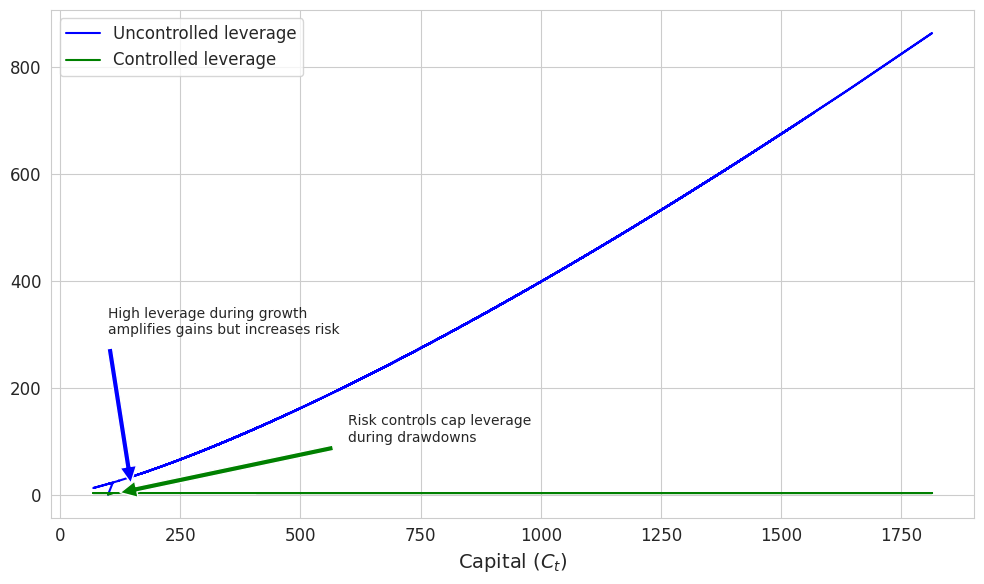

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(C, l, 'b-', label='Uncontrolled leverage')
plt.plot(C, l_controlled, 'g-', label='Controlled leverage')
plt.xlabel('Capital ($C_t$)')
plt.legend()
plt.grid(True)
plt.annotate('High leverage during growth\namplifies gains but increases risk',
             xy=(150, 8), xytext=(100, 300),
             arrowprops=dict(facecolor='blue', shrink=0.05),
             fontsize=10)
plt.annotate('Risk controls cap leverage\nduring drawdowns',
             xy=(100, 0), xytext=(600, 100),
             arrowprops=dict(facecolor='green', shrink=0.05),
             fontsize=10)
plt.tight_layout()
plt.savefig("leverage-founction-cap.pdf")
plt.show()
